<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [2]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

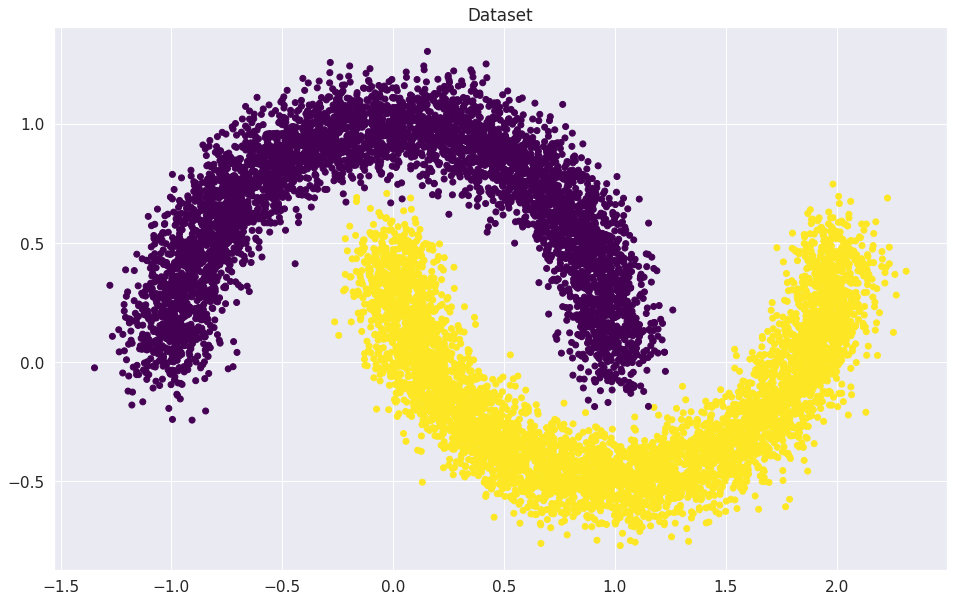

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
X_train_t =  torch.FloatTensor(X_train)  # YOUR CODE GOES HERE
y_train_t =  torch.FloatTensor(y_train)  # YOUR CODE GOES HERE
X_val_t =  torch.FloatTensor(X_val)  # YOUR CODE GOES HERE
y_val_t =  torch.FloatTensor(y_val) # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.ones(100000, 1)) # YOUR CODE GOES HERE

    def forward(self, x):
        x =  x @ self.weights  # YOUR CODE GOES HERE
        if self.bias:
            # self.bias_term = nn.Parameter(self.bias_term[0:x.shape[0]])
            x +=  self.bias_term[0:x.shape[0]] # YOUR CODE GOES HERE
        return x

In [9]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

Ответ: 4

In [10]:
print(list(linear_regression.parameters()))

[Parameter containing:
tensor([[ 0.9995],
        [-0.4321]], requires_grad=True), Parameter containing:
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], requires_grad=True)]


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [11]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch)
        outp = outp.view(-1) # YOUR CODE. Use linear_regression to get outputs
        loss = loss_function(outp, y_batch) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  F.softmax(outp, dim=-1)  # YOUR CODE. Compute probabilities F.softmax()
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.515625
Iteration: 100
Batch accuracy: 0.453125
Iteration: 200
Batch accuracy: 0.5390625
Iteration: 300
Batch accuracy: 0.421875
Iteration: 400
Batch accuracy: 0.5234375
Iteration: 500
Batch accuracy: 0.5078125
Iteration: 600
Batch accuracy: 0.59375
Iteration: 700
Batch accuracy: 0.484375
Iteration: 800
Batch accuracy: 0.46875

Iteration: 814.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**
  696

### Визуализируем результаты

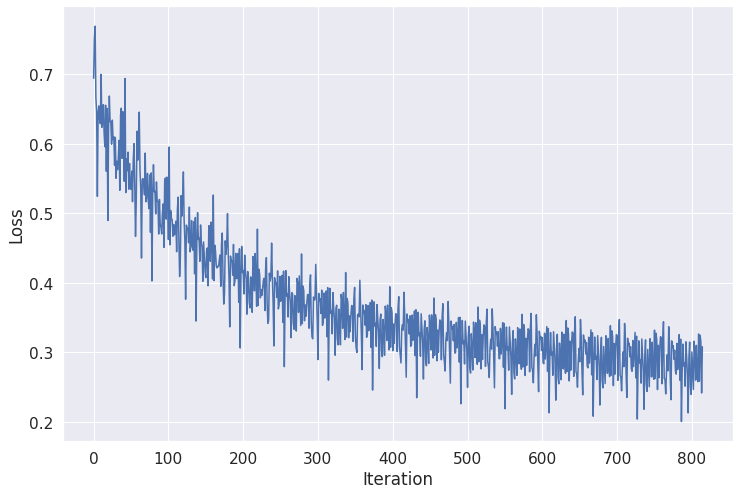

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

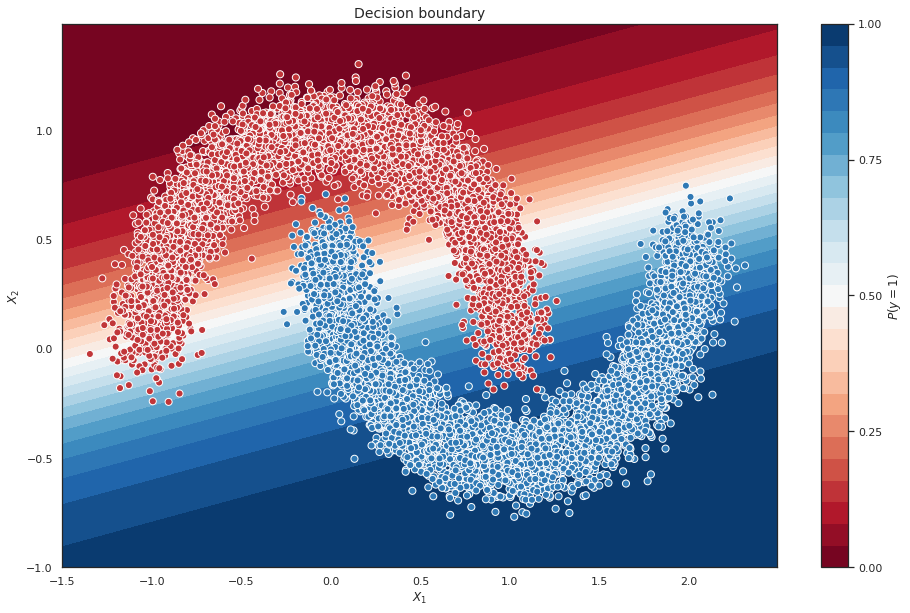

In [13]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [14]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        # <YOUR CODE>
        preds = model(x_batch)
        preds = F.softmax(preds, dim=-1)
        preds = (preds > 0.5).type(torch.long)
          #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [15]:
from sklearn.metrics import accuracy_score

prd = predict(val_dataloader, linear_regression)
print(accuracy_score(prd, y_val))

# YOUR CODE. Compute total accuracy

0.4912


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 
0.4912

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [16]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128) # YOUR CODE GOES HERE
valid_dataloader =  DataLoader(val_dataset, batch_size=128) # YOUR CODE GOES HERE

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [17]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [18]:

activation = nn.ELU
print(activation())
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
    #YOUR CODE. Add layers to your sequential class
)


ELU(alpha=1.0)


In [19]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [21]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            # accuracy['train'] = loss
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = torch.argmax(outp, dim=1)
            # print(preds)
            correct = (preds==y_batch).cpu().numpy().mean()
            # print(correct) # YOUR CODE GOES HERE
            all = 1
            # print(all) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        # print(epoch_all)
        # print(epoch_correct)
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8803193852167733
Loader: valid. Accuracy: 0.9302808544303798
Epoch: 2
Loader: train. Accuracy: 0.9432358297796731
Loader: valid. Accuracy: 0.9527294303797469
Epoch: 3
Loader: train. Accuracy: 0.9602101101634685
Loader: valid. Accuracy: 0.9615308544303798
Epoch: 4
Loader: train. Accuracy: 0.9691553393745558
Loader: valid. Accuracy: 0.9655854430379747
Epoch: 5
Loader: train. Accuracy: 0.9751854566453447
Loader: valid. Accuracy: 0.9666732594936709
Epoch: 6
Loader: train. Accuracy: 0.9797718994314143
Loader: valid. Accuracy: 0.9627175632911392
Epoch: 7
Loader: train. Accuracy: 0.9831201137171286
Loader: valid. Accuracy: 0.9603441455696202
Epoch: 8
Loader: train. Accuracy: 0.9844860518834398
Loader: valid. Accuracy: 0.9654865506329114
Epoch: 9
Loader: train. Accuracy: 0.9844527363184079
Loader: valid. Accuracy: 0.9691455696202531
Epoch: 10
Loader: train. Accuracy: 0.986135172352523
Loader: valid. Accuracy: 0.9727056962025317


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [22]:
elu_accuracy = accuracy["valid"]


In [23]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
  act = activation
  model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    act(),
    nn.Linear(128, 128),
    act(),
    nn.Linear(128, 10))
  max_epochs = 10
  accuracy = {"train": [], "valid": []}
  criterion = nn.CrossEntropyLoss()  
  optimizer = torch.optim.Adam(model.parameters())
  loaders = {"train": train_dataloader, "valid": valid_dataloader}
  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              if k == "train":
                  model.train()
                  optimizer.zero_grad()
                  outp = model(x_batch)
                  # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
              if k == "valid":
                  model.eval()
                  with torch.no_grad():
                      outp = model(x_batch)
              # accuracy['train'] = loss
                  # YOUR CODE. Set model to ``eval`` mode and calculate outputs
              preds = torch.argmax(outp, dim=1)
              # print(preds)
              correct = (preds==y_batch).cpu().numpy().mean()
              # print(correct) # YOUR CODE GOES HERE
              all = 1
              # print(all) # YOUR CODE GOES HERE
              epoch_correct += correct.item()
              epoch_all += all
              if k == "train":
                  loss = criterion(outp, y_batch)
                  loss.backward()
                  optimizer.step()
                  # YOUR CODE. Calculate gradients and make a step of your optimizer
          if k == "train":
              print(f"Epoch: {epoch+1}")
          # print(epoch_all)
          # print(epoch_correct)
          print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          if k == "valid":
            accuracy[k].append(epoch_correct/epoch_all)  
  
  
  return accuracy['valid']  #YOUR CODE

In [24]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.863278473702914
Loader: valid. Accuracy: 0.8818235759493671
Epoch: 2
Loader: train. Accuracy: 0.8951281538734898
Loader: valid. Accuracy: 0.9006131329113924
Epoch: 3
Loader: train. Accuracy: 0.9000866204690832
Loader: valid. Accuracy: 0.9022943037974683
Epoch: 4
Loader: train. Accuracy: 0.9027851812366737
Loader: valid. Accuracy: 0.9020965189873418
Epoch: 5
Loader: train. Accuracy: 0.9041233564321252
Loader: valid. Accuracy: 0.9011075949367089
Epoch: 6
Loader: train. Accuracy: 0.9055003997867804
Loader: valid. Accuracy: 0.9009098101265823
Epoch: 7
Loader: train. Accuracy: 0.9065664978678039
Loader: valid. Accuracy: 0.9009098101265823
Epoch: 8
Loader: train. Accuracy: 0.9078713574982232
Loader: valid. Accuracy: 0.9016020569620253
Epoch: 9
Loader: train. Accuracy: 0.9092539534470505
Loader: valid. Accuracy: 0.9021954113924051
Epoch: 10
Loader: train. Accuracy: 0.9102534203980099
Loader: valid. Accuracy: 0.903184335443038
Epoch: 1
Loader: train. Accurac

In [25]:
Tahn_accuracy = test_activation_function(nn.Tanh)


Epoch: 1
Loader: train. Accuracy: 0.886543843283582
Loader: valid. Accuracy: 0.936807753164557
Epoch: 2
Loader: train. Accuracy: 0.9448905028429282
Loader: valid. Accuracy: 0.9552017405063291
Epoch: 3
Loader: train. Accuracy: 0.9606321073205402
Loader: valid. Accuracy: 0.961629746835443
Epoch: 4
Loader: train. Accuracy: 0.9679615316275764
Loader: valid. Accuracy: 0.9623219936708861
Epoch: 5
Loader: train. Accuracy: 0.9732142857142857
Loader: valid. Accuracy: 0.963310917721519
Epoch: 6
Loader: train. Accuracy: 0.976667999289268
Loader: valid. Accuracy: 0.9665743670886076
Epoch: 7
Loader: train. Accuracy: 0.9787446695095949
Loader: valid. Accuracy: 0.9673655063291139
Epoch: 8
Loader: train. Accuracy: 0.9811489427860697
Loader: valid. Accuracy: 0.9639042721518988
Epoch: 9
Loader: train. Accuracy: 0.9813044154228855
Loader: valid. Accuracy: 0.9688488924050633
Epoch: 10
Loader: train. Accuracy: 0.9820040422885572
Loader: valid. Accuracy: 0.9645965189873418


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

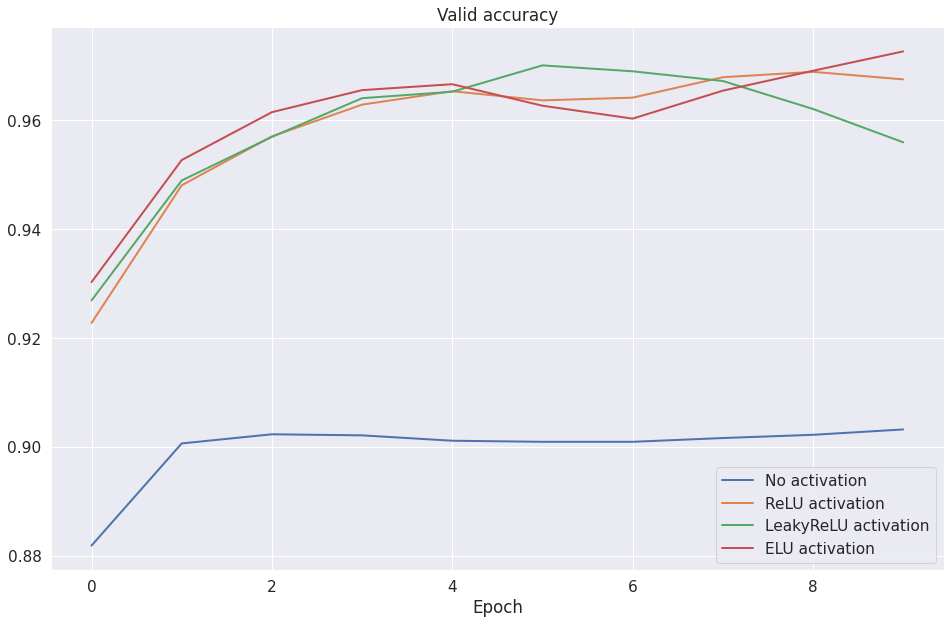

In [26]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

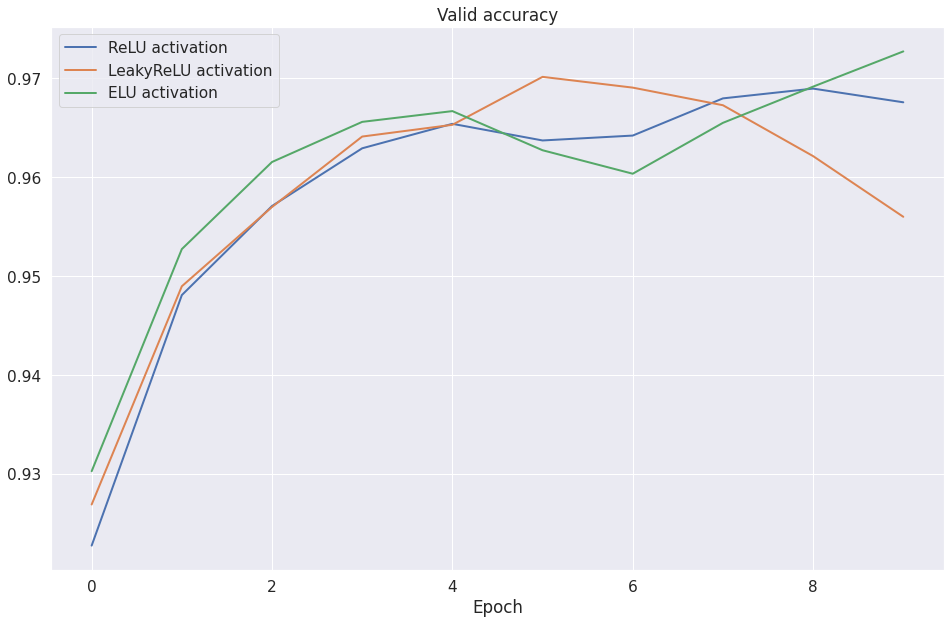

In [27]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [28]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-11-11 13:55:16--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-11-11 13:55:17--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   159KB/s    in 0.3s    

2022-11-11 13:55:18 (159 KB/s) - ‘sample_photo.jpg’ saved [49337/4

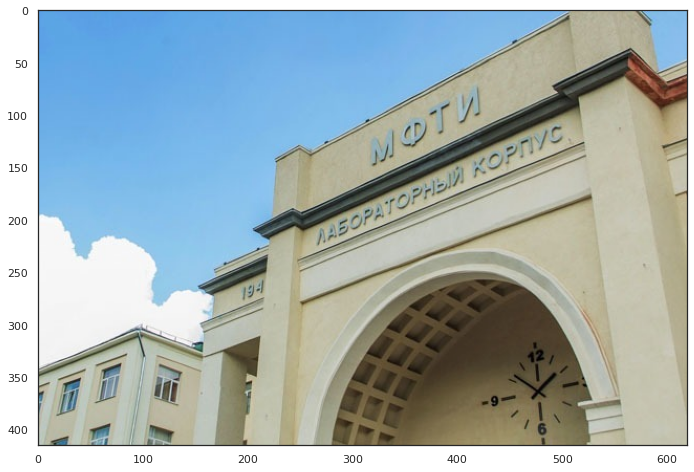

In [29]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [30]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

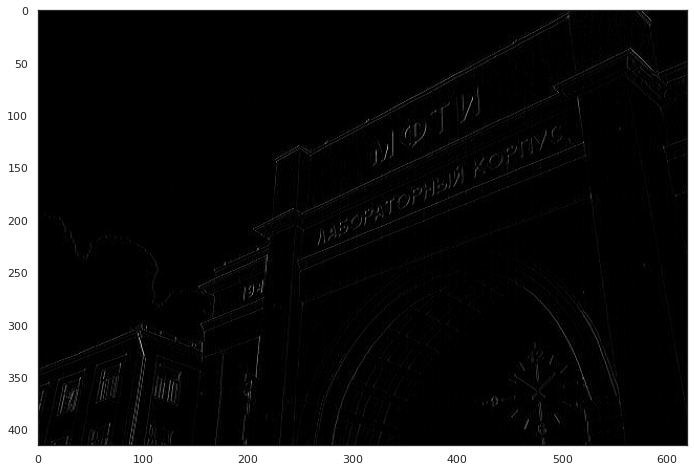

In [31]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие Е

2) Увеличение резкости Д

3) Тождественное преобразование А

4) Выделение вертикальных границ В

5) Выделение горизонтальных границ Б

6) Выделение границ Г

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [65]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  #YOUR CODE
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)  #YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  #YOUR CODE
        self.fc1 = nn.Linear(400, 120)  #YOUR CODE  
        self.fc2 = nn.Linear(120, 84)  #YOUR CODE
        self.fc3 = nn.Linear(84, 10)
        self.flt = nn.Flatten()  #YOUR CODE

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  #YOUR CODE. Apply layers created in __init__. 
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flt(x)
        # x = x.view(-1, 51200)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [66]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [68]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                # print(x_batch.shape)
                outp = model(x_batch)
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            # accuracy['train'] = loss
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = torch.argmax(outp, dim=1)
            # print(preds)
            correct = (preds==y_batch).cpu().numpy().mean()
            # print(correct) # YOUR CODE GOES HERE
            all = 1
            # print(all) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        # print(epoch_all)
        # print(epoch_correct)
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9839863184079601
Loader: valid. Accuracy: 0.9841772151898734
Epoch: 2
Loader: train. Accuracy: 0.9869180881307746
Loader: valid. Accuracy: 0.9848694620253164
Epoch: 3
Loader: train. Accuracy: 0.9892002043354655
Loader: valid. Accuracy: 0.9862539556962026
Epoch: 4
Loader: train. Accuracy: 0.9906494314143568
Loader: valid. Accuracy: 0.9868473101265823
Epoch: 5
Loader: train. Accuracy: 0.9923818407960199
Loader: valid. Accuracy: 0.9861550632911392
Epoch: 6
Loader: train. Accuracy: 0.9930148365316276
Loader: valid. Accuracy: 0.9857594936708861
Epoch: 7
Loader: train. Accuracy: 0.993897699004975
Loader: valid. Accuracy: 0.9854628164556962
Epoch: 8
Loader: train. Accuracy: 0.9948971659559346
Loader: valid. Accuracy: 0.9865506329113924
Epoch: 9
Loader: train. Accuracy: 0.9950748489694385
Loader: valid. Accuracy: 0.9840783227848101
Epoch: 10
Loader: train. Accuracy: 0.9954635305614783
Loader: valid. Accuracy: 0.9868473101265823


In [69]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

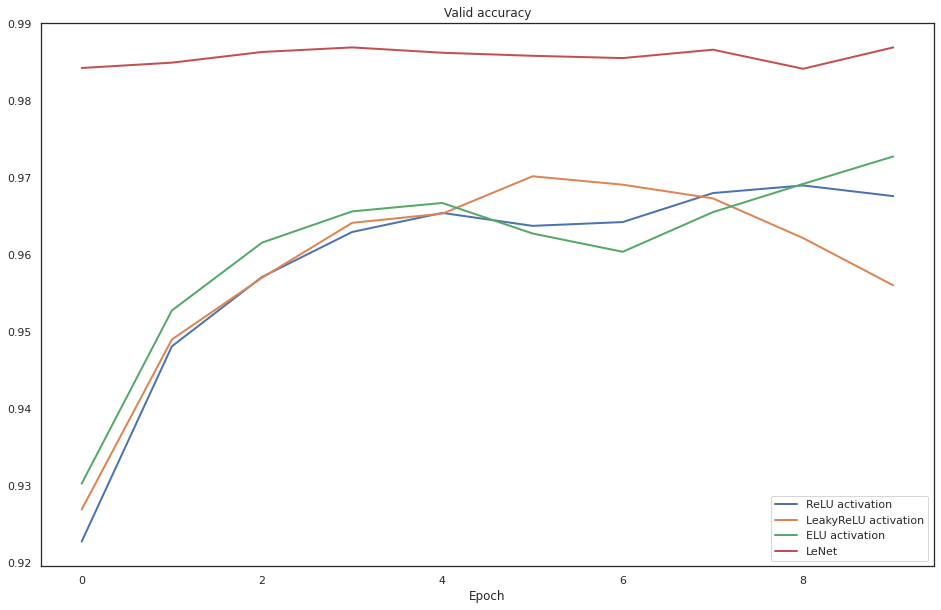

In [70]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**
0.99